In [4]:
%config Completer.use_jedi = False

import ipywidgets as widgets
import pandas as pd
from datetime import datetime

import pandas as pd

import matplotlib.pyplot as plt

import glob

import numpy as np

import seaborn as sns

# NIFTY Index time series analysis

## Load and join all Nifty OHLC

Download Historical OHLC data for indexes from here: 
https://www1.nseindia.com/products/content/equities/indices/historical_index_data.htm

And put it in `Data/<index/underlying>/OHLC`

In [5]:
data_df = pd.concat([pd.read_csv(f, parse_dates=['Date'], index_col=['Date']) for f in glob.glob('../Data/Nifty/OHLC/*.csv',)], 
                    join='outer')

In [6]:
data_df.tail()

,Open,High,Low,Close,Shares Traded,Turnover (Rs. Cr)
Date,,,,,,
2021-09-13,17363.55,17378.35,17269.15,17355.30,241053924,18498.63
2021-09-14,17420.35,17438.55,17367.05,17380.00,230354386,18702.82
2021-09-15,17387.65,17532.70,17386.90,17519.45,388191629,24256.80
2021-09-16,17539.20,17644.60,17510.45,17629.50,503310763,30189.77
2021-09-17,17709.65,17792.95,17537.65,17585.15,508285916,43345.58


## Load and join options data

Download Options chain data for indexes from here: 
https://www1.nseindia.com/products/content/derivatives/equities/historical_fo.htm

And put it in `Data/<index/underlying>/Options`

In [7]:
options_df = pd.concat([pd.read_csv(f, parse_dates=['Date'], index_col=['Date']) for f in glob.glob('../Data/Nifty/Options/*.csv',)], 
                    join='outer')

In [8]:
# Filter for latest data
options_df = options_df[options_df.index.max()==options_df.index]

### Data Sanity Checks

In [9]:
options_df.Expiry.unique()

array(['23-Sep-2021'], dtype=object)

In [10]:
options_df.columns

Index(['Symbol', 'Expiry', 'Option Type', 'Strike Price', 'Open', 'High',
       'Low', 'Close', 'LTP', 'Settle Price', 'No. of contracts',
       'Turnover in Lacs', 'Premium Turnover in Lacs', 'Open Int',
       'Change in OI', 'Underlying Value'],
      dtype='object')

In [11]:
# Check whether we got both PE and CE
options_df['Option Type'].unique()

array(['CE', 'PE'], dtype=object)

In [12]:
# Keep relevant Columns only
options_df = options_df[['Symbol', 'Strike Price', 'Option Type', 'Expiry', 'Close','No. of contracts']]

In [13]:
options_df.shape

(200, 6)

In [14]:
sum(options_df['No. of contracts']>1000)

96

In [15]:
# Get rid of contracts which are not actively traded
options_df = options_df[options_df['No. of contracts']>1000]

#TODO check for missing data

In [16]:
# Check for duplicates
data_df.duplicated().sum()

0

Check the start date and end date

In [17]:
data_df.index.min()

Timestamp('2018-01-02 00:00:00')

In [18]:
data_df.index.max()

Timestamp('2021-09-17 00:00:00')

In [19]:
options_df.index.min()

Timestamp('2021-09-20 00:00:00')

In [20]:
options_df.index.max()

Timestamp('2021-09-20 00:00:00')

## Stationarizing and Differencing

Let's have a look at the raw data before processing it

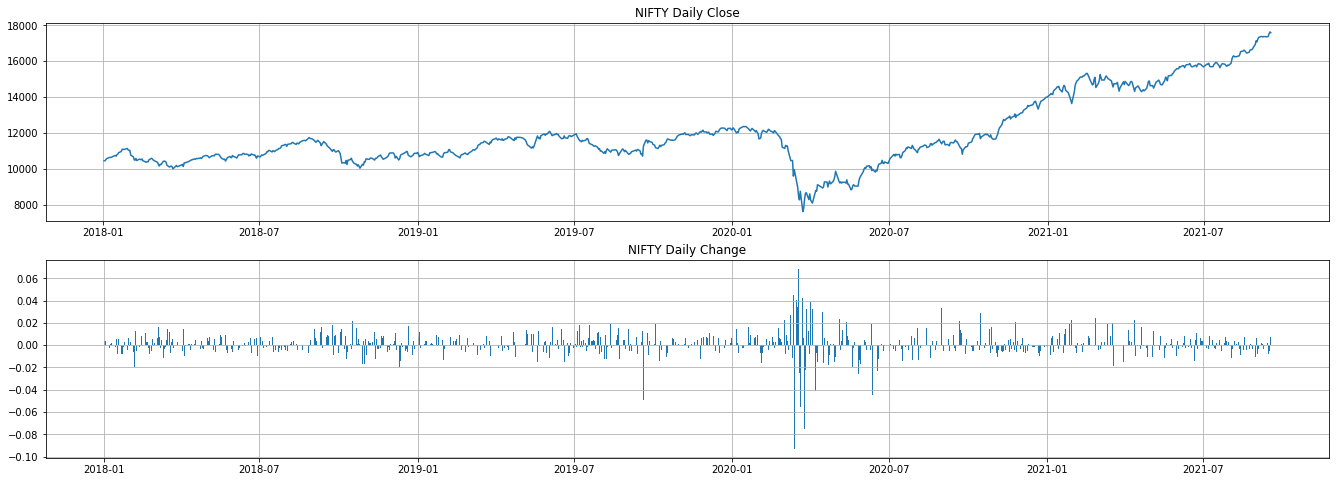

In [21]:
fig = plt.figure(figsize=(23,8))
ax = fig.add_subplot(211)
ax.plot(data_df.Close)
ax.grid()
ax.set_title('NIFTY Daily Close')
# fig = plt.figure(figsize=(23,5))
ax = fig.add_subplot(212)
ax.bar(data_df.index, (data_df.Open - data_df.Close)/data_df.Open)
ax.set_title('NIFTY Daily Change')
ax.grid()

**Stationarization and Differencing**

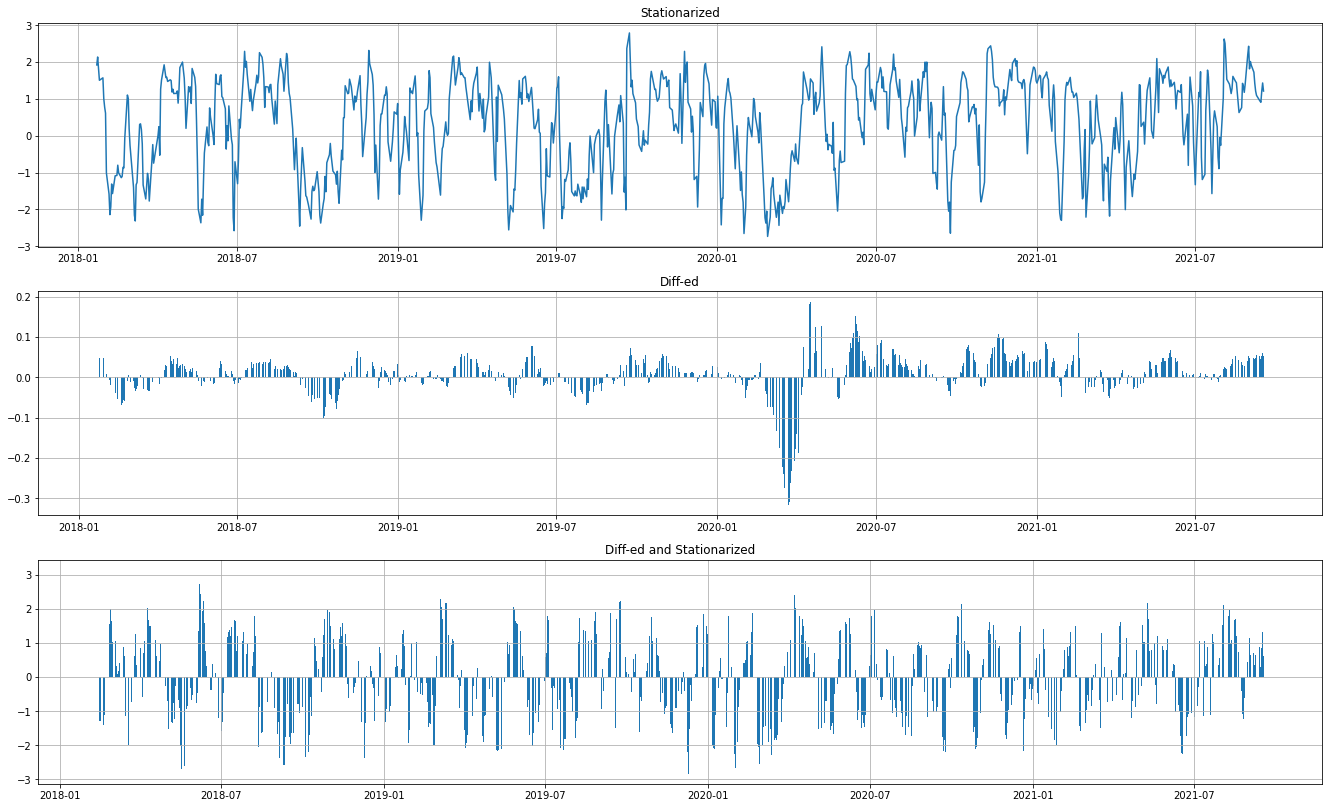

In [22]:
trade_days_left = 15 # used as window size
fig = plt.figure(figsize=(23,14))
ax = fig.add_subplot(311)
ax.plot(data_df.Close.rolling(trade_days_left).apply(lambda x: (x[-1]-x.mean())/x.std()))
ax.grid()
ax.set_title('Stationarized')
ax = fig.add_subplot(312)
ax.bar(data_df.index, data_df.Close.rolling(trade_days_left).apply(lambda x: (x[-1]-x[0])/x[0]))
ax.set_title('Diff-ed')
ax.grid()
ax = fig.add_subplot(313)
ax.bar(data_df.index, data_df.Close.rolling(trade_days_left).apply(lambda x: (x[-1]-x[0])).rolling(trade_days_left).apply(lambda x: (x[-1]-x.mean())/x.std()))
ax.set_title('Diff-ed and Stationarized')
# ax.bar(data_df.index, (data_df.Open - data_df.Close).rolling(20).apply(lambda x: (x[-1]-x.mean())/x.std()))
ax.grid()

# Period Rate of Change Analysis

Since this is dependent on the option's expiry date we are  choosing the number of trading days left as the period.

In [23]:
trade_days_left = 3 # used as window size
period_change = data_df.Close.rolling(trade_days_left).apply(lambda x: (x[-1]-x[0])/x[0]).dropna()

period_open = data_df.Open.rolling(trade_days_left).apply(lambda x: x[0]).dropna()

period_high = data_df.High.rolling(trade_days_left).apply(lambda x: x.max()).dropna()

period_low = data_df.Low.rolling(trade_days_left).apply(lambda x: x.min()).dropna()

period_pos_change = (period_high - period_open)/period_open
period_neg_change = (period_low - period_open)/period_open

Let's visualize the distribution of how much the underlying can change within the period

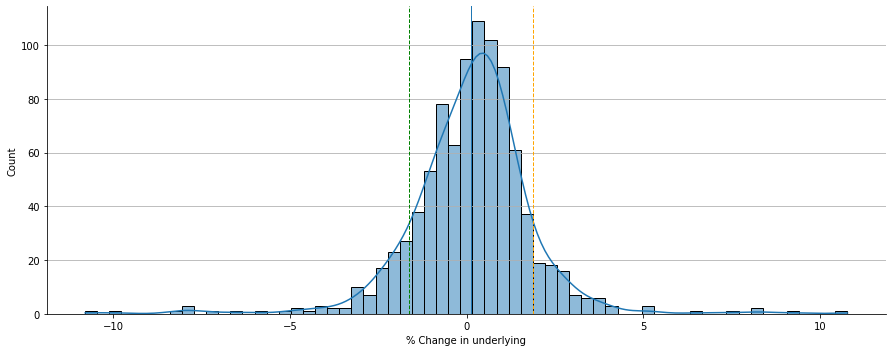

In [24]:
ax = sns.displot(data=period_change*100,kde=True, aspect=2.5)
ax.set_axis_labels(x_var='% Change in underlying')
plt.grid(axis='y')

plt.axvline(x=100*period_change.mean(), 
#             color='blue', 
            linewidth=1.0, 
            linestyle='-')
plt.axvline(x=100*(period_change.mean()-period_change.std()), 
            color='green', 
            linewidth=1.0, 
            linestyle='--')
plt.axvline(x=100*(period_change.mean()+period_change.std()), 
            color='orange', 
            linewidth=1.0, 
            linestyle='--')

In [25]:
period_change.mean()

0.0012961055056699407

In [26]:
period_change.std()

0.017564215464984954

In [27]:
(period_change>0).sum()/len(period_change)

0.5775109170305677

In [28]:
(period_change<0).sum()/len(period_change)

0.42248908296943233

Over the time period 57% of all changes were positive 42.5% were negative

## Probability of change

## Probability of $mean \pm \sigma$ change

In [29]:
expected_change_neg_sigma = period_change.mean() - period_change.std()
prob_change_neg_sigma = (period_change<expected_change_neg_sigma).sum()/len(period_change)
print("%.3f probability of < %.2f%% change" %(prob_change_neg_sigma, expected_change_neg_sigma*100))

0.107 probability of < -1.63% change


In [30]:
expected_change_pos_sigma = period_change.mean() + period_change.std()
prob_change_pos_sigma = (period_change>expected_change_pos_sigma).sum()/len(period_change)
print("%.3f probability of > %.f%% change" %(prob_change_pos_sigma, expected_change_pos_sigma*100))

0.092 probability of > 2% change


## Probability of $\pm 1$% change

In [31]:
expected_change = 0.01
prob_change = (period_change>expected_change).sum()/len(period_change)
print("%.3f probability of > %.f%% change" %(prob_change, expected_change*100))

0.241 probability of > 1% change


In [32]:
expected_change = -0.01
prob_change = (period_change<expected_change).sum()/len(period_change)
print("%.3f probability of < %.f%% change" %(prob_change, expected_change*100))

0.188 probability of < -1% change


In [33]:
period_change.describe()

count    916.000000
mean       0.001296
std        0.017564
min       -0.107988
25%       -0.007056
50%        0.002292
75%        0.009671
max        0.107729
Name: Close, dtype: float64

In [34]:
# Set the last price
last_price = data_df.Close[-1]

In [36]:
last_price = 17562

# Options Chain Analysis

## Calculate the probabilty of expiry above the strike price

We want to calculate:
- How much change is required in the underlying in order for a contract to expire ITM
- What is the probability of the underlying price changing by that much before expiry

In [37]:
upper_bound = 18750
lower_bound = 16750
options_df = options_df[options_df['Strike Price']<upper_bound]
options_df = options_df[options_df['Strike Price']>lower_bound]

In [38]:

# Separate out Call and Put option
ce_df = options_df[options_df['Option Type']=='CE']
pe_df = options_df[options_df['Option Type']=='PE']

# Filter out ITM
ce_df = ce_df[ce_df['Strike Price']>last_price]
pe_df = pe_df[pe_df['Strike Price']<last_price]


ce_df = ce_df.sort_values('Strike Price')
pe_df = pe_df.sort_values('Strike Price')

# Filter ITM options
ce_df = ce_df[ce_df['Strike Price']>last_price]
pe_df = pe_df[pe_df['Strike Price']<last_price]


# Change percent
ce_change = ((ce_df['Strike Price'] - last_price)/last_price).values
pe_change = ((pe_df['Strike Price'] - last_price)/last_price).values

# Calculate Probabilty of out of the money call options expiring in the money
proba_atm_expiry_ce = np.zeros_like(ce_change)
for idx in range(len(ce_df)):
    proba_atm_expiry_ce[idx] = np.apply_along_axis(lambda x : x > ce_change[idx],
                                                   axis=0,
                                                   arr=period_change).mean()

strike_price_ce = ce_df['Strike Price'].values

# Calculate Probabilty of out of the money put options expiring in the moeny
proba_atm_expiry_pe = np.zeros_like(pe_change)
for idx in range(len(pe_df)):
    proba_atm_expiry_pe[idx] = np.apply_along_axis(lambda x : x < pe_change[idx],
                                                axis=0,
                                                arr=period_change).mean()

strike_price_pe = pe_df['Strike Price'].values

### Probabilty vs Cost
Lets visualize the probability of ITM expiry and the cost of investing in one lot of the contract.

Text(0.5, 1.0, 'Cost = CE Price x Lot')

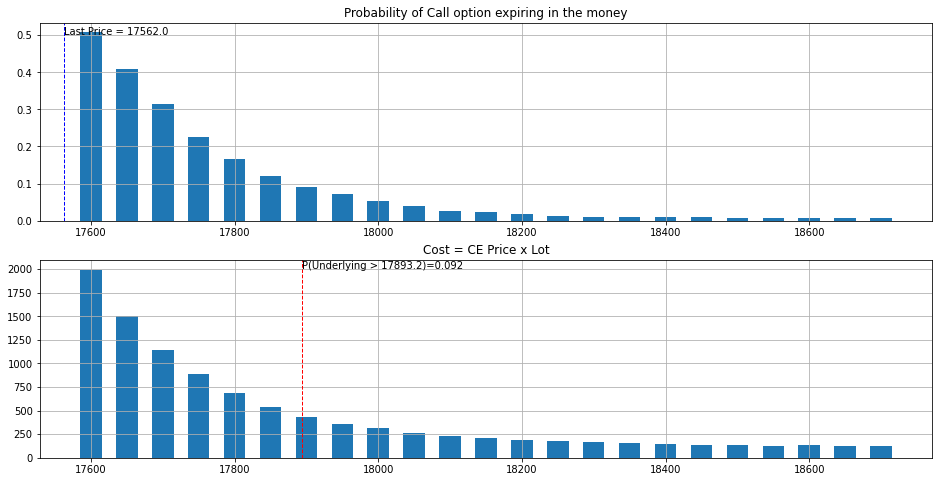

In [39]:
fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(211)
ax.bar(x=strike_price_ce, height=proba_atm_expiry_ce, width=30)
ax.grid()
ax.set_title('Probability of Call option expiring in the money')
plt.axvline(x=last_price, color='b', linewidth=1.0, linestyle='--')
plt.text(last_price,
         0.5,
         'Last Price = %.1f'%last_price, 
         rotation=0)
ax = fig.add_subplot(212)
ax.bar(x=strike_price_ce, height=50*ce_df['Close'].values, width=30)
ax.grid(which='major')

sigma_high = last_price*(1+expected_change_pos_sigma)
plt.axvline(x=sigma_high, color='r', linewidth=1.0, linestyle='--')
plt.text(sigma_high,
         2000,
         'P(Underlying > %.1f)=%.3f'%(sigma_high,prob_change_pos_sigma), 
         rotation=0)

ax.set_title('Cost = CE Price x Lot')



Text(0.5, 1.0, 'Cost = PE Price x Lot')

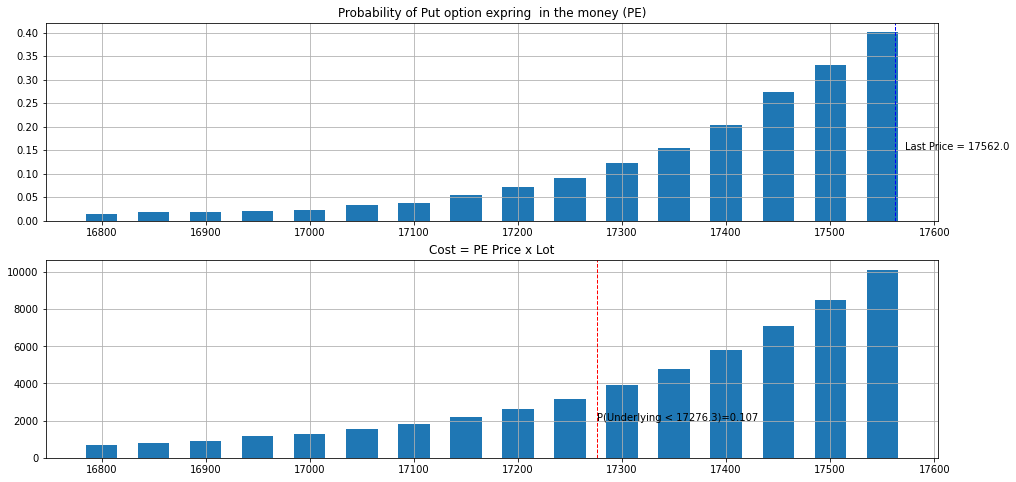

In [40]:
fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(211)
ax.bar(x=strike_price_pe, height=proba_atm_expiry_pe, width=30)
ax.grid()
ax.set_title('Probability of Put option expring  in the money (PE)')
plt.axvline(x=last_price, color='b', linewidth=1.0, linestyle='--')
plt.text(last_price+10,
         0.15,
         'Last Price = %.1f'%last_price, 
         rotation=0)
ax = fig.add_subplot(212)
ax.bar(x=strike_price_pe, height=50*pe_df['Close'].values, width=30)
ax.grid(which='major')
sigma_low = last_price*(1+expected_change_neg_sigma)
plt.axvline(x=sigma_low, color='r', linewidth=1.0, linestyle='--')
plt.text(sigma_low,
         2000,
         'P(Underlying < %.1f)=%.3f'%(sigma_low,prob_change_neg_sigma), 
         rotation=0)

ax.set_title('Cost = PE Price x Lot')

Putting it all together

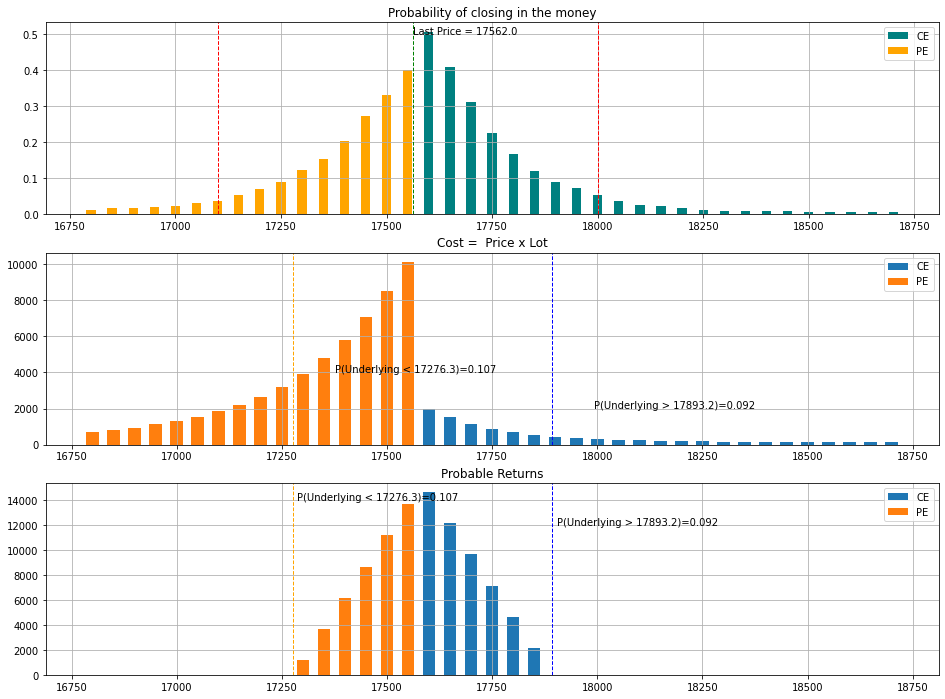

In [41]:

ce_contract = 18000
pe_contract = 17100

fig = plt.figure(figsize=(16,12))

ax = fig.add_subplot(311)

# Plot CE
ax.bar(x=strike_price_ce, 
       height=proba_atm_expiry_ce, 
       width=22, 
       color='teal', 
       align='center', 
       label='CE')

# Plot PE
ax.bar(x=strike_price_pe, height=proba_atm_expiry_pe, 
       width=22,
       color='orange', 
       align='center', 
       label='PE')

ax.grid()
ax.set_title('Probability of closing in the money')

plt.axvline(x=last_price, color='g', linewidth=1.0, linestyle='--')
plt.text(last_price,
         0.5,
         'Last Price = %.1f'%last_price, 
         rotation=0)
ax.legend()


plt.axvline(x=ce_contract, color='red', linewidth=1.0, linestyle='--')
plt.axvline(x=pe_contract, color='red', linewidth=1.0, linestyle='--')

cost_ce = 50*ce_df['Close'].values
cost_pe = 50*pe_df['Close'].values

ax = fig.add_subplot(312)

ax.bar(x=strike_price_ce, height=cost_ce, width=30, label='CE')
ax.bar(x=strike_price_pe, height=cost_pe, width=30, label='PE')
ax.grid(which='major')

sigma_high = last_price*(1+expected_change_pos_sigma)
plt.axvline(x=sigma_high, color='blue', linewidth=1.0, linestyle='--')
plt.text(sigma_high+100,
         2000,
         'P(Underlying > %.1f)=%.3f'%(sigma_high,prob_change_pos_sigma), 
         rotation=0)

ax.set_title('Cost =  Price x Lot')

# ax = fig.add_subplot(313)
sigma_low = last_price*(1+expected_change_neg_sigma)
plt.axvline(x=sigma_low, color='orange', linewidth=1.0, linestyle='--')
plt.text(sigma_low+100,
         4000,
         'P(Underlying < %.1f)=%.3f'%(sigma_low,prob_change_neg_sigma), 
         rotation=0)
ax.legend()

# Profits when underlying expires at mean +/- std
probable_profits_ce = 50*(sigma_high-strike_price_ce)
probable_profits_pe = 50*(strike_price_pe-sigma_low)

# Zero out the loss making contracts
probable_profits_pe[probable_profits_pe<0] = 0
probable_profits_ce[probable_profits_ce<0] = 0


ax = fig.add_subplot(313)
ax.bar(x=strike_price_ce, height=probable_profits_ce, width=30, label='CE')
ax.bar(x=strike_price_pe, height=probable_profits_pe, width=30, label='PE')
ax.grid(which='major')


plt.axvline(x=sigma_high, color='blue', linewidth=1.0, linestyle='--')
plt.text(sigma_high+10,
         12000,
         'P(Underlying > %.1f)=%.3f'%(sigma_high,prob_change_pos_sigma), 
         rotation=0)

ax.set_title('Probable Returns')

plt.axvline(x=sigma_low, color='orange', linewidth=1.0, linestyle='--')
plt.text(sigma_low+10,
         14000,
         'P(Underlying < %.1f)=%.3f'%(sigma_low,prob_change_neg_sigma), 
         rotation=0)

ax.legend()

As expected, both probability of closing in the money and cost of investing, goes down the further away we go from the last closing price of the underlying.

We want to:
- Maximize Returns
- Minimize Costs
- Maximize Probabilty of closing ITM

### Returns vs Cost vs Probabilty

We calculate probability/cost because when buying an options contract, we are essentially buying probability that it will expire ITM. Thus it makes sense to find the best value (probability) for money contract.

Similarly, we also want to maximize returns. `Probable Returns / Cost` gives us a good understanding of what would provide the highest ROI.

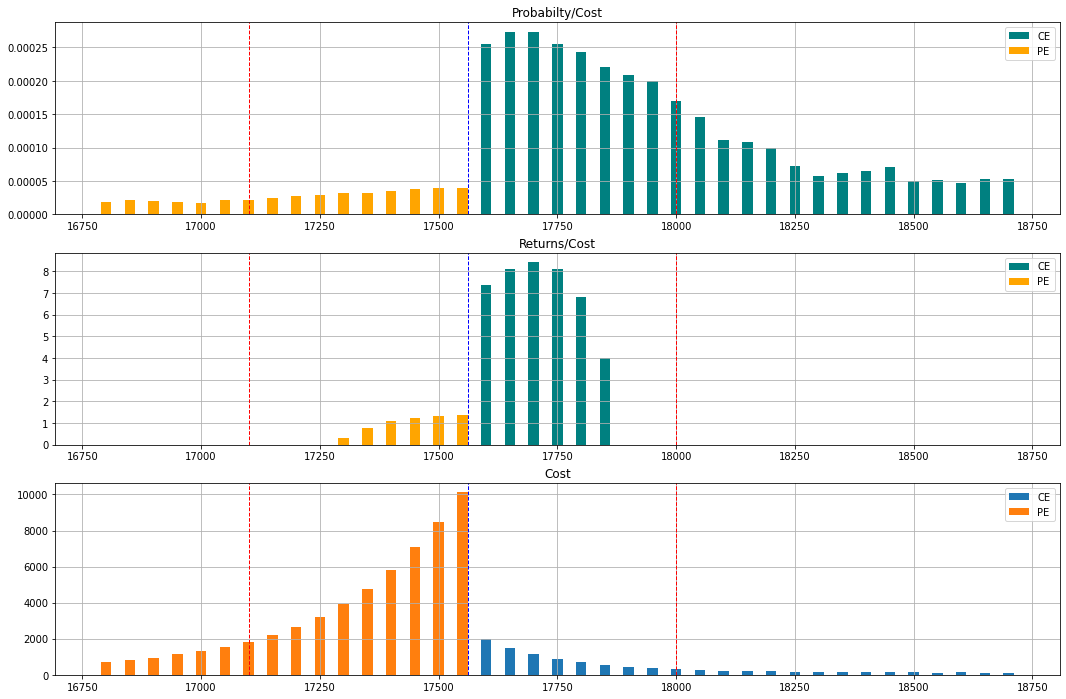

In [42]:
fig = plt.figure(figsize=(18,12))

ax = fig.add_subplot(311)
ax.set_title('Probabilty/Cost')

# Plot CE
ax.bar(x=strike_price_ce, 
       height=proba_atm_expiry_ce/cost_ce, 
       width=22, 
       color='teal', 
       align='center', 
       label='CE')

# Plot PE
ax.bar(x=strike_price_pe, 
       height=proba_atm_expiry_pe/cost_pe, 
       width=22, 
       color='orange', 
       align='center', 
       label='PE')

plt.axvline(x=last_price, color='blue', linewidth=1.0, linestyle='--')
plt.axvline(x=ce_contract, color='red', linewidth=1.0, linestyle='--')
plt.axvline(x=pe_contract, color='red', linewidth=1.0, linestyle='--')

ax.legend()
ax.grid()


ax = fig.add_subplot(312)

ax.set_title('Returns/Cost')

# Plot CE
ax.bar(x=strike_price_ce, 
       height=probable_profits_ce/cost_ce, 
       width=22, 
       color='teal', 
       align='center', 
       label='CE')


plt.axvline(x=last_price, color='blue', linewidth=1.0, linestyle='--')
plt.axvline(x=ce_contract, color='red', linewidth=1.0, linestyle='--')
plt.axvline(x=pe_contract, color='red', linewidth=1.0, linestyle='--')

# Plot PE
ax.bar(x=strike_price_pe, 
       height=probable_profits_pe/cost_pe, 
       width=22, 
       color='orange', 
       align='center', 
       label='PE')

ax.legend()
ax.grid()


ax = fig.add_subplot(313)

ax.set_title('Cost')

# Zero out the loss making contracts
probable_profits_pe[probable_profits_pe<0] = 0
probable_profits_ce[probable_profits_ce<0] = 0

# Plot CE
ax.bar(x=strike_price_ce, 
       height=cost_ce, 
       width=22,  
       align='center', 
       label='CE')

# Plot PE
ax.bar(x=strike_price_pe, 
       height=cost_pe, 
       width=22, 
       align='center', 
       label='PE')


plt.axvline(x=last_price, color='blue', linewidth=1.0, linestyle='--')
plt.axvline(x=ce_contract, color='red', linewidth=1.0, linestyle='--')
plt.axvline(x=pe_contract, color='red', linewidth=1.0, linestyle='--')

ax.legend()
ax.grid()

### MinMaxing - Minimizing Maximum Loss

We have to pick OTM PE-CE pairs

Optimizing for 3 metrics
- Probability
    - probability of closing in the money ($P(expiry > (strike+tax))$)
    - probability of covering the entire position ($P(R_i > C)$)
- Returns $R_i$
- Cost per contract $c_i$

Cost of position is constrained by:
$$\sum_{i=1}^{n} c_{i} < C$$
Since sum of all position costs (c<sub>n</sub>) should be less than invested capital C.

We want to minimize probability of maximum loss

We can do this by maximizing:
 $P(R_i > C$)  - for each call and put option pair.


Which is the same as choosing 
 - call options with max $P(U > S_c + C)$
 - put options with max $P(U < S_p - C)$
 
 $U$ : Underlying Price (at expiry)
  
 $S_p$ : Put option Strike price 
 
 $S_c$ : Call option Strike price 

In [43]:
def add_option_lines(ce_positions, pe_positions, last_price=None, line_width=2.0):
    if last_price is not None:
        plt.axvline(x=last_price, color='royalblue', linewidth=line_width, linestyle='--', label="Last Close: %d"%last_price)
        
    for ce_contract in ce_positions:
        plt.axvline(x=ce_contract, color='darkgreen', linewidth=line_width, linestyle='--', label="%d CE"%ce_contract)
    
    for pe_contract in pe_positions:
        plt.axvline(x=pe_contract, color='tomato', linewidth=line_width, linestyle='--', label="%d PE"%pe_contract)

In [44]:
upper_level = 17750
expected_change = (upper_level - last_price)/last_price
prob_change = (period_change>expected_change).sum()/len(period_change)
print("%.3f probability of expiring above %d" %(prob_change, upper_level))

lower_level = 17000
expected_change = (lower_level - last_price)/last_price
prob_change = (period_change<expected_change).sum()/len(period_change)
print("%.3f probability of expiring below %d" %(prob_change, lower_level))

0.226 probability of expiring above 17750
0.023 probability of expiring below 17000


In [45]:
capital = 5000
lot_size = 50
expected_rate = 0.01
tax = 20 # placeholder in Rs
capital_breakeven = (capital*(1+expected_rate)+tax)/lot_size

In [46]:

# Separate out Call and Put option
ce_df = options_df[options_df['Option Type']=='CE']
pe_df = options_df[options_df['Option Type']=='PE']

# Filter out ITM
ce_df = ce_df[ce_df['Strike Price']>last_price]
pe_df = pe_df[pe_df['Strike Price']<last_price]


ce_df = ce_df.sort_values('Strike Price')
pe_df = pe_df.sort_values('Strike Price')

# Filter out options we can't invest in due to capital constraints
ce_df = ce_df[(ce_df['Close']*lot_size)<capital]
pe_df = pe_df[(pe_df['Close']*lot_size)<capital]

# Change percent required to break even on the full capital
ce_change_breakeven = ((ce_df['Strike Price'] + capital_breakeven - last_price)/last_price).values
pe_change_breakeven = ((pe_df['Strike Price'] - capital_breakeven - last_price)/last_price).values

# Change percent
ce_change = ((ce_df['Strike Price'] - last_price)/last_price).values
pe_change = ((pe_df['Strike Price'] - last_price)/last_price).values


# Calculate Probabilty of call options breeaking even on the entire capital
proba_breakeven_ce = np.zeros_like(ce_change_breakeven)
for idx in range(len(ce_df)):
    proba_breakeven_ce[idx] = np.apply_along_axis(lambda x : x > ce_change_breakeven[idx],
                                                   axis=0,
                                                   arr=period_pos_change).mean()
#                                                    arr=period_change).mean()

strike_price_ce = ce_df['Strike Price'].values

# Calculate Probabilty of out of the money put options expiring in the moeny
proba_breakeven_pe = np.zeros_like(pe_change_breakeven)
for idx in range(len(pe_df)):
    proba_breakeven_pe[idx] = np.apply_along_axis(lambda x : x < pe_change_breakeven[idx],
                                                axis=0,
                                                arr=period_neg_change).mean()
#                                                 arr=period_change).mean()

strike_price_pe = pe_df['Strike Price'].values

# Calculate Probabilty of out of the money call options expiring in the money
proba_atm_expiry_ce = np.zeros_like(ce_change)
for idx in range(len(ce_df)):
    proba_atm_expiry_ce[idx] = np.apply_along_axis(lambda x : x > ce_change[idx],
                                                   axis=0,
                                                   arr=period_change).mean()


# Calculate Probabilty of out of the money put options expiring in the moeny
proba_atm_expiry_pe = np.zeros_like(pe_change)
for idx in range(len(pe_df)):
    proba_atm_expiry_pe[idx] = np.apply_along_axis(lambda x : x < pe_change[idx],
                                                axis=0,
                                                arr=period_change).mean()

sigma_high = last_price*(1+expected_change_pos_sigma)
sigma_low = last_price*(1+expected_change_neg_sigma)
# Profits when underlying expires at mean +/- std
probable_profits_ce = lot_size*(sigma_high-strike_price_ce)
probable_profits_pe = lot_size*(strike_price_pe-sigma_low)

# Zero out the loss making contracts
probable_profits_pe[probable_profits_pe<0] = 0
probable_profits_ce[probable_profits_ce<0] = 0


Pick your positions

In [47]:
ce_positions = [17550]
pe_positions = [17200]

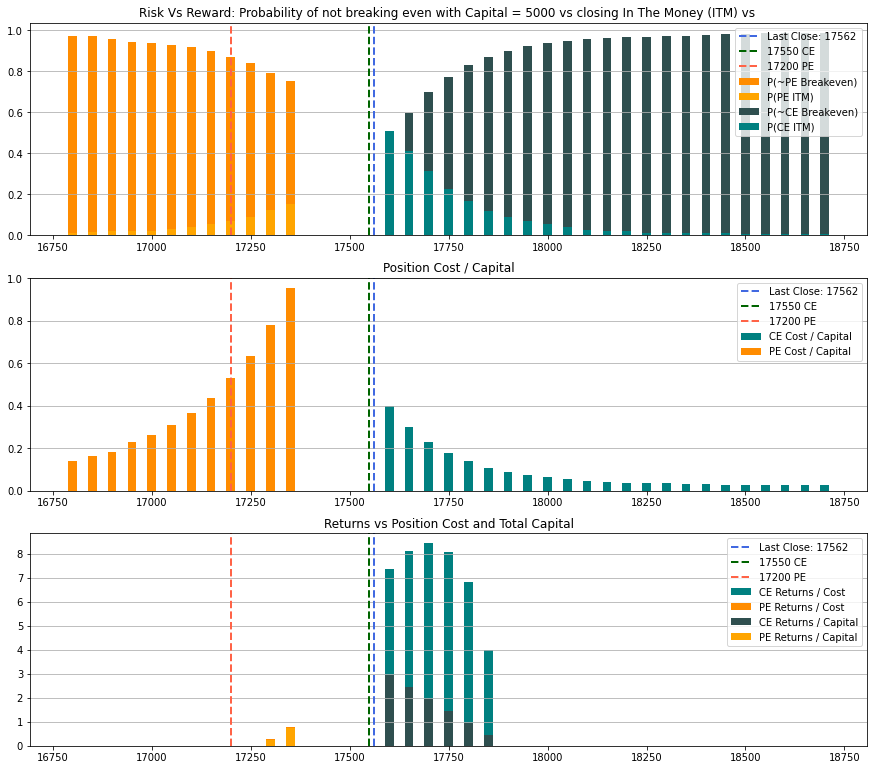

In [48]:
cost_ce = lot_size*ce_df['Close'].values
cost_pe = lot_size*pe_df['Close'].values

# Break Even Analysis
fig = plt.figure(figsize=(15,18))

ax = fig.add_subplot(411)



# Plot PE
ax.bar(x=strike_price_pe, 
       height=1-proba_breakeven_pe, 
       width=22, 
       color='darkorange', 
       align='center', 
       label='P(~PE Breakeven)')


# Plot PE
ax.bar(x=strike_price_pe, height=proba_atm_expiry_pe, 
       width=22,
       color='orange', 
       align='center', 
       label='P(PE ITM)')


# Plot CE
ax.bar(x=strike_price_ce, 
       height=1-proba_breakeven_ce, 
       width=22, 
       color='darkslategray', 
       align='center', 
       label='P(~CE Breakeven)')


# Plot CE
ax.bar(x=strike_price_ce, 
       height=proba_atm_expiry_ce, 
       width=22, 
       color='teal', 
       align='center', 
       label='P(CE ITM)')


# ax.grid()
ax.set_title('Risk Vs Reward: Probability of not breaking even with Capital = %d vs closing In The Money (ITM) vs '%capital)


add_option_lines(ce_positions=ce_positions,pe_positions=pe_positions, last_price=last_price)
ax.legend()
ax.grid(axis='y')



# Probable profit analysis

ax = fig.add_subplot(413)

ax.set_title('Returns vs Position Cost and Total Capital')

# Plot CE
ax.bar(x=strike_price_ce, 
       height=probable_profits_ce/cost_ce, 
       width=22, 
       color='teal', 
       align='center', 
       label='CE Returns / Cost')


# Plot PE
ax.bar(x=strike_price_pe, 
       height=probable_profits_pe/cost_pe, 
       width=22, 
       color='darkorange', 
       align='center', 
       label='PE Returns / Cost')


# Plot CE
ax.bar(x=strike_price_ce, 
       height=probable_profits_ce/capital, 
       width=22, 
       color='darkslategray', 
       align='center', 
       label='CE Returns / Capital')


# Plot PE
ax.bar(x=strike_price_pe, 
       height=probable_profits_pe/capital, 
       width=22, 
       color='orange', 
       align='center', 
       label='PE Returns / Capital')

add_option_lines(ce_positions=ce_positions,pe_positions=pe_positions, last_price=last_price)
ax.legend()
ax.grid(axis='y')

ax = fig.add_subplot(412)

ax.set_title('Position Cost / Capital')

# Plot CE
ax.bar(x=strike_price_ce, 
       height= cost_ce/capital, 
       width=22, 
       color='teal', 
       align='center', 
       label='CE Cost / Capital')


add_option_lines(ce_positions=ce_positions,pe_positions=pe_positions, last_price=last_price)

# Plot PE
ax.bar(x=strike_price_pe, 
       height= cost_pe/capital, 
       width=22, 
       color='darkorange', 
       align='center', 
       label='PE Cost / Capital')

ax.legend()
ax.grid(axis='y')




In [49]:
capital = 2500
lot_size = 50
tax = 0 # placeholder in Rs
capital_breakeven = (capital+tax)/lot_size

# Change percent required to break even on the full capital
ce_change_breakeven = ((ce_df['Strike Price'] + capital_breakeven - last_price)/last_price).values
pe_change_breakeven = ((pe_df['Strike Price'] - capital_breakeven - last_price)/last_price).values

# Calculate Probabilty of call options breeaking even on the entire capital
proba_breakeven_ce = np.zeros_like(ce_change_breakeven)
for idx in range(len(ce_df)):
    proba_breakeven_ce[idx] = np.apply_along_axis(lambda x : x > ce_change_breakeven[idx],
                                                   axis=0,
                                                   arr=period_change).mean()

strike_price_ce = ce_df['Strike Price'].values

# Calculate Probabilty of out of the money put options expiring in the moeny
proba_breakeven_pe = np.zeros_like(pe_change_breakeven)
for idx in range(len(pe_df)):
    proba_breakeven_pe[idx] = np.apply_along_axis(lambda x : x < pe_change_breakeven[idx],
                                                axis=0,
                                                arr=period_change).mean()

strike_price_pe = pe_df['Strike Price'].values

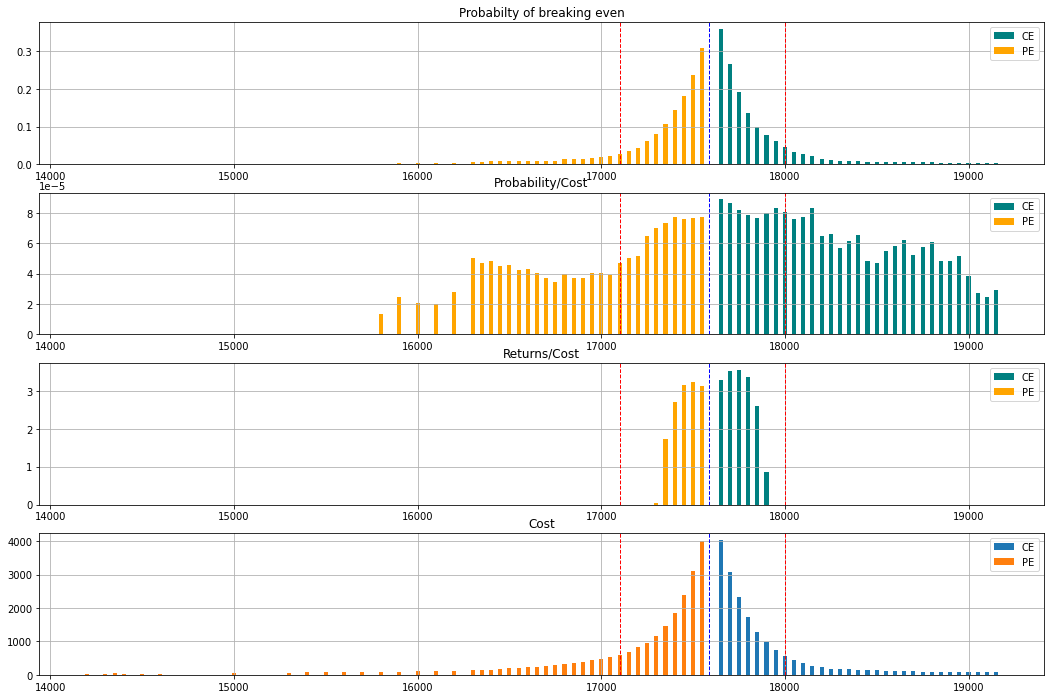

In [91]:
fig = plt.figure(figsize=(18,12))

ax = fig.add_subplot(411)
ax.set_title('Probabilty of breaking even')

# Plot CE
ax.bar(x=strike_price_ce, 
       height=proba_breakeven_ce, 
       width=22, 
       color='teal', 
       align='center', 
       label='CE')

# Plot PE
ax.bar(x=strike_price_pe, 
       height=proba_breakeven_pe, 
       width=22, 
       color='orange', 
       align='center', 
       label='PE')

plt.axvline(x=last_price, color='blue', linewidth=1.0, linestyle='--')
plt.axvline(x=ce_contract, color='red', linewidth=1.0, linestyle='--')
plt.axvline(x=pe_contract, color='red', linewidth=1.0, linestyle='--')

ax.legend()
ax.grid()


ax = fig.add_subplot(412)

ax.set_title('Probability/Cost')

# Plot CE
ax.bar(x=strike_price_ce, 
       height=proba_breakeven_ce/cost_ce, 
       width=22, 
       color='teal', 
       align='center', 
       label='CE')


plt.axvline(x=last_price, color='blue', linewidth=1.0, linestyle='--')
plt.axvline(x=ce_contract, color='red', linewidth=1.0, linestyle='--')
plt.axvline(x=pe_contract, color='red', linewidth=1.0, linestyle='--')

# Plot PE
ax.bar(x=strike_price_pe, 
       height=proba_breakeven_pe/cost_pe, 
       width=22, 
       color='orange', 
       align='center', 
       label='PE')

ax.legend()
ax.grid()

ax = fig.add_subplot(413)

ax.set_title('Returns/Cost')

# Plot CE
ax.bar(x=strike_price_ce, 
       height=probable_profits_ce/cost_ce, 
       width=22, 
       color='teal', 
       align='center', 
       label='CE')


plt.axvline(x=last_price, color='blue', linewidth=1.0, linestyle='--')
plt.axvline(x=ce_contract, color='red', linewidth=1.0, linestyle='--')
plt.axvline(x=pe_contract, color='red', linewidth=1.0, linestyle='--')

# Plot PE
ax.bar(x=strike_price_pe, 
       height=probable_profits_pe/cost_pe, 
       width=22, 
       color='orange', 
       align='center', 
       label='PE')

ax.legend()
ax.grid()

ax = fig.add_subplot(414)

ax.set_title('Cost')

# Zero out the loss making contracts
probable_profits_pe[probable_profits_pe<0] = 0
probable_profits_ce[probable_profits_ce<0] = 0

# Plot CE
ax.bar(x=strike_price_ce, 
       height=cost_ce, 
       width=22,  
       align='center', 
       label='CE')

# Plot PE
ax.bar(x=strike_price_pe, 
       height=cost_pe, 
       width=22, 
       align='center', 
       label='PE')


plt.axvline(x=last_price, color='blue', linewidth=1.0, linestyle='--')
plt.axvline(x=ce_contract, color='red', linewidth=1.0, linestyle='--')
plt.axvline(x=pe_contract, color='red', linewidth=1.0, linestyle='--')

ax.legend()
ax.grid()

# Future Risk nd Returns
## Cumulative probability
Probabilty of  ~0.1 might not seem like much but if we calculate the cumulative probabilty over multiple trials (i.e. what would happen if we consistently made investments like this):

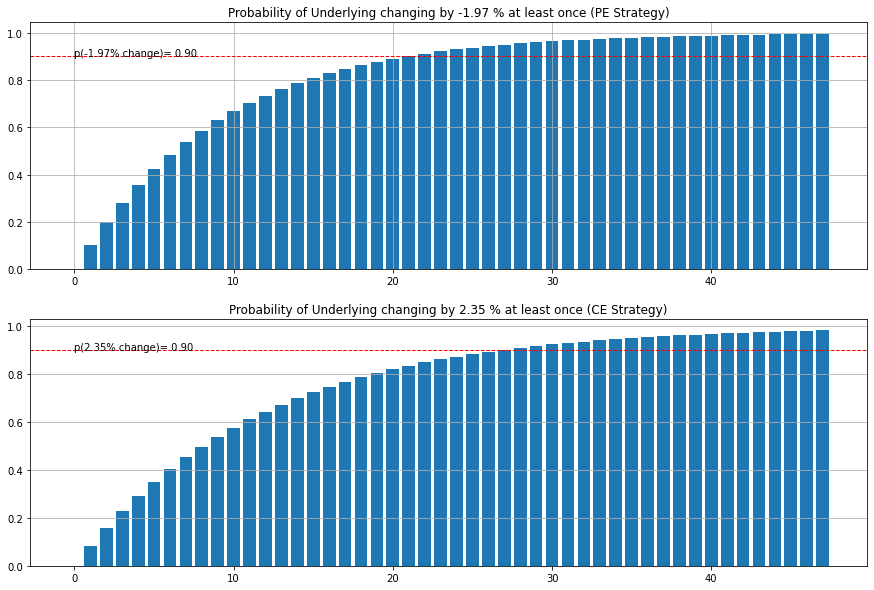

In [114]:
fig = plt.figure(figsize=(15,10))
threshold = 0.9
num_periods = range(48)

ax = fig.add_subplot(211)
ax.bar(num_periods,[1-(1-prob_change_neg_sigma)**(periods) for periods in num_periods])
plt.axhline(y=threshold, color='r', linewidth=1.0, linestyle='--')
plt.text(0,
         threshold,
         'p(%.2f%% change)= %.2f'%(expected_change_neg_sigma*100, threshold), 
         rotation=0)
ax.set_title('Probability of Underlying changing by %.2f %% at least once (PE Strategy)'% (100*expected_change_neg_sigma))
ax.grid()

ax = fig.add_subplot(212)
ax.bar(num_periods,[1-(1-prob_change_pos_sigma)**(periods) for periods in num_periods])
plt.axhline(y=threshold, color='r', linewidth=1.0, linestyle='--')
plt.text(0,
         threshold,
         'p(%.2f%% change)= %.2f'%(expected_change_pos_sigma*100, threshold), 
         rotation=0)
ax.set_title('Probability of Underlying changing by %.2f %% at least once (CE Strategy)'% (100*expected_change_pos_sigma))
ax.grid(axis='y')

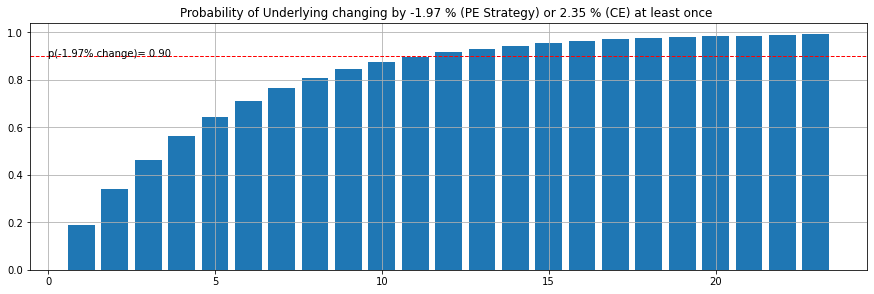

In [115]:
fig = plt.figure(figsize=(15,10))
threshold = 0.9
num_periods = range(1,24)

ax = fig.add_subplot(211)
ax.bar(num_periods,[1-(1-(prob_change_neg_sigma+prob_change_pos_sigma))**(periods) for periods in num_periods])
plt.axhline(y=threshold, color='r', linewidth=1.0, linestyle='--')
plt.text(0,
         threshold,
         'p(%.2f%% change)= %.2f'%(expected_change_neg_sigma*100, threshold), 
         rotation=0)
ax.set_title('Probability of Underlying changing by %.2f %% (PE Strategy) or %.2f %% (CE) at least once '% (100*expected_change_neg_sigma, 100*expected_change_pos_sigma))
ax.grid()

So probabilistically speaking:
- theres a 90% chance (P=0.9), the CE strategy will succeed at least once in 28 trials.
- theres a 90% chance (P=0.9), the PE strategy will succeed at least once in 22 trials.
- But a 90% chance (P=0.9), that either will succeed at least once in 12 trials

For a deeper understanding of why this happens, you can read more here: 

[Why “Crime Doesn’t Pay” but risky bets on the stock market do — Probabilistically Speaking](https://shayanrc.medium.com/why-crime-doesnt-pay-but-risky-bets-on-the-stock-market-do-probabilistically-speaking-8eb1ca24fa34)


**Question**: What is the probability of a strategy succeeding at least twice/thrice/__k__

## Predicting the win rate using Laplace's Rule of Succession

Laplace's Rule of Succession (generalized to multinomial distributions):

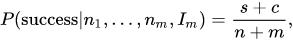




Where

- **s** : No. of successes
- **c** : No. of categories of outcomes which can be considered a success.
- **n** : No. of trials
- **m** : No. of categories of outcomes

In the case of the PE strategy:
- **s** is the count of when the underlying decreased by mean - standard deviation
- **c** is 1 as there is only one outcome where it succeeds
- **n** number of trials is equal to the number of windowed observations we have
- **m** is 4, if we consider 4 probable outcomes:
   - Contract(s) expire < `mean - standard deviation`
   - Contract(s) expire > `mean + standard deviation`
   - Contract(s) expire > 0 but, < `mean + standard deviation`
   - Contract(s) expire <= 0 but, > `mean - standard deviation`
        


In [42]:
s = (period_change < expected_change_neg_sigma).sum()
c = 1
n = len(period_change)
m = 4

(s+c)/(n+m)

0.1050328227571116

Lets calculate for CE Options Contract

In [43]:
s = (period_change > expected_change_pos_sigma).sum()
c = 1
n = len(period_change)
m = 5

(s+c)/(n+m)

0.08306010928961749

If we add our CE strategy into the mix to cover half of the outcome space, **c** becomes 2

In [43]:
s = ((period_change < expected_change_neg_sigma) | (period_change > expected_change_pos_sigma)).sum()
c = 2
n = len(period_change)
m = 4

(s+c)/(n+m)

0.18798665183537264

Let's caclulate the probability of futures going up

In [44]:
s = (period_change > 0).sum()
c = 1
n = len(period_change)
m = 4

(s+c)/(n+m)

0.5706340378197998

If we add that to our strategy mix we can cover 3/4th of the outcome space:

In [45]:
s = ((period_change < expected_change_neg_sigma) | (period_change > expected_change_pos_sigma) | (period_change > 0)).sum()
c = 3
n = len(period_change)
m = 4

(s+c)/(n+m)

0.6763070077864294

That is the closest we can get to predicting the win rate, but it is a very good aproximation of our strategy making money.

The scenario where CE and PE both fail simultaneously:

In [46]:
s = ((period_change > expected_change_neg_sigma) & (period_change < expected_change_pos_sigma)).sum()
c = 2
n = len(period_change)
m = 4

(s+c)/(n+m)

0.8120133481646273

The scenario where CE, PE and FUT strategy all fail simultaneously:

In [47]:
n = len(period_change)
s = n - ((period_change < expected_change_neg_sigma) | (period_change > expected_change_pos_sigma) | (period_change > 0)).sum()
c = 1

m = 4

(s+c)/(n+m)

0.3236929922135706

## SIP Calculation

In [134]:
rate = 0.1
principal = 5000
num_periods = 52
amount = ((principal*(1+rate)**num_periods)/(rate))*(1+rate)
amount

7812361.259143756

# Next
- ~~Filter out OTM Options only~~
- ~~Calculate Probabilty/Cost~~
- ~~Calculate Returns/Cost~~
- ~~Combine with cumulative probability~~
- Win Rate prediction
- Interactivity


### Interactivity Tests (WIP)

In [48]:
start_date = datetime(2018, 4, 24)
end_date = datetime(2018, 5, 24)

dates = pd.date_range(start_date, end_date, freq='D')

options = [(date.strftime(' %d %b %Y '), date) for date in dates]
index = (0, len(options)-1)

selection_range_slider = widgets.SelectionRangeSlider(
    options=options,
    index=index,
    description='Dates',
    orientation='horizontal',
    layout={'width': '500px'}
)

selection_range_slider

SelectionRangeSlider(description='Dates', index=(0, 30), layout=Layout(width='500px'), options=((' 24 Apr 2018…

In [49]:
def print_date_range(date_range):
     print(date_range)

widgets.interact(
    df = print_date_range,
    date_range=selection_range_slider
);